**Test the BioNER model on N2C2 2018 Track 2 dataset using trained Clinical-BERT. Save to /output**

**Test script for BERT-LR baseline**

**Data versions**
- v1 = Sentence-level input + Overlap filtering + max seq len(~192)
- (BEST)v2 = reduced max seq length to ~100

**Model versions**
- v1 = Bio_Discharge_Summary_BERT(data=v1)
- v2 = Bio_Discharge_Summary_BERT(data=v1) trained with weights, scheduler
- v3 = reduced max seq length 128 , 150 epoch, 16 batch, 2e-5 lr(val= 70)
- (BEST)v4 = reduced max seq length 128 , 150 epoch, 32 batch, 3e-5 lr, dropout = 0.1(val= 70, test(strict)= 72.5, test(lenient)= 84)

Note- max seq length ~350 (Stopped as the f1 was 0.40 at 80th epoch)


# Initialize Parameters

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
DATA_VER = "v2"
MODEL_VER = "v4"
PARENT_DIR = "/content/gdrive/My Drive/projects/biomedical_ner"
TEST_DIR = PARENT_DIR + "/data/" + DATA_VER + "/test"
MODEL_DIR = PARENT_DIR + "/model/" + MODEL_VER
OUTPUT_DIR = PARENT_DIR + "/output/" + MODEL_VER

VOCAB_PATH = MODEL_DIR + "/vocab.txt"
CONFIG_PATH = MODEL_DIR + "/config.json"
PREDICTIONS_PATH = OUTPUT_DIR + "/predictions.csv"
REPORT_PATH = OUTPUT_DIR + "/result.txt"
CONFUSION_MATRIX_PATH = OUTPUT_DIR + "/confusion_matrix.csv"
SCORES_PATH = OUTPUT_DIR + "/scores.csv"

In [ ]:
import os
if not os.path.exists(OUTPUT_DIR):
  os.makedirs(OUTPUT_DIR)

In [ ]:
batch_size = 16
max_len = 272 # tried 384
pad_label = "X"

# Requirements Installation

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

!pip install seqeval
!pip install transformers

     |████████████████████████████████| 51kB 4.6MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp36-none-any.whl size=16171 sha256=ddef5f19a5f63c88d47070d96b94e71b06d48b490b2d3c8dd54ca5e20ad26f3e
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval
     |████████████████████████████████| 1.3MB 7.4MB/s 
     |████████████████████████████████| 1.1MB 22.5MB/s 
     |████████████████████████████████| 890kB 41.1MB/s 
     |████████████████████████████████| 2.9MB 41.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=7a13ed845da6f9777c9db783587750b240f2781cc20d318b20cecf62c1ff5fd4
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


# Imports

In [ ]:
import pandas as pd
import math
import numpy as np
from seqeval.metrics import f1_score
from seqeval.metrics import classification_report,accuracy_score,f1_score
import torch.nn.functional as F

import torch
import os
from tqdm import tqdm,trange
from torch.optim import Adam
from torch.utils.data import DataLoader, SequentialSampler, Dataset, ConcatDataset
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import AutoConfig, AutoModelForTokenClassification, AutoTokenizer, BertTokenizer, BertForTokenClassification
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
# Check library version
!pip list | grep -E 'transformers|torch|Keras'

Keras                         2.4.3          
Keras-Preprocessing           1.1.2          
torch                         1.7.0+cu101    
torchsummary                  1.5.1          
torchtext                     0.3.1          
torchvision                   0.8.1+cu101    
transformers                  3.5.1          


# Setup Mapping

In [ ]:
tag2idx = {'B-Drug': 0,
          'I-Drug': 1,
          'B-Reason': 2,
          'I-Reason': 3,
          'B-ADE': 4,
          'I-ADE': 5,
          'O': 6,
          'X': 7,
          '[CLS]': 8,
          '[SEP]': 9
          }
tag2name = {tag2idx[key] : key for key in tag2idx.keys()}

# Setup GPU

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
n_gpu

1

# Prepare Data

In [ ]:
!ls '$TEST_DIR' | wc -l

202


In [ ]:
class ClinicalDataset(Dataset):
    def __init__(self, file, path, max_seq_len, tag2idx, tokenizer):
        self.max_seq_len = max_seq_len;
        self.path = os.path.join(path, file)
        self.df = pd.read_csv(self.path, names=['patientID', 'sentenceID', 'token', 'tag'], keep_default_na=False)
        self.tag2idx = tag2idx
        self.tokenizer = tokenizer
        # Convert Tokens to indices
        self.prepare_data()

    def prepare_data(self):
        sentences, labels = self.get_sentences(self.df)
        tokenized_texts, word_piece_labels = self.tokenize_text(sentences, labels)

        # Make text token into id
        input_ids = pad_sequences([self.tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                                  maxlen=self.max_seq_len, dtype="long", truncating="post", padding="post")

        # Make label into id, pad with "O" meaning others/wrong
        tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in word_piece_labels],
                             maxlen=self.max_seq_len, value=self.tag2idx[pad_label],
                             padding="post", dtype="long", truncating="post")
        
        input_text = pad_sequences([txt for txt in tokenized_texts],
                                  maxlen=self.max_seq_len, value = "[PAD]", 
                                   padding="post", dtype=object, truncating="post")
        
        y_text.extend(input_text)

        # For fine tune of predict, with token mask is 1,pad token is 0
        attention_masks = [[int(i > 0) for i in ii] for ii in input_ids]
        
        self.Sentences = torch.tensor(input_ids)
        self.label_data = torch.tensor(tags)
        self.attention_masks = torch.tensor(attention_masks)

    def get_sentences(self, data):
        agg_func = lambda s: [(w, t) for w, t in zip(s["token"].values.tolist(), s["tag"].values.tolist())]
        grouped = data.groupby("sentenceID").apply(agg_func)
        tokenstags = [s for s in grouped]
        sentences = [[s[0] for s in sent] for sent in tokenstags]
        labels = [[s[1] for s in sent] for sent in tokenstags]
        return sentences, labels

    def tokenize_text(self, sentences, labels):
        tokenized_texts = []
        word_piece_labels = []
        i_inc = 0
        for word_list, label in (zip(sentences,labels)):
            temp_label = []
            temp_token = []

            # Add [CLS] at the front
            temp_label.append('[CLS]')
            temp_token.append('[CLS]')

            for word,lab in zip(word_list,label):
                token_list = self.tokenizer.tokenize(word)
                for m,token in enumerate(token_list):
                    temp_token.append(token)
                    if lab.startswith('B'):
                        if m==0:
                            temp_label.append(lab)
                        else:
                            temp_label.append('I-'+lab.split('-')[1])
                    else:
                        temp_label.append(lab)

            # Add [SEP] at the end
            temp_token.append('[SEP]')
            temp_label.append('[SEP]')

            tokenized_texts.append(temp_token)
            word_piece_labels.append(temp_label)

        return tokenized_texts, word_piece_labels

    def __len__(self):
        return len(self.Sentences)

    def __getitem__(self, idx):
        return self.Sentences[idx], self.attention_masks[idx], self.label_data[idx]

In [ ]:
# Tokenizer
tokenizer = BertTokenizer(vocab_file=VOCAB_PATH)

In [ ]:
# TEST DATASET
test_datasets = []
y_text = []
for doc in os.listdir(TEST_DIR):
    test_datasets.append(ClinicalDataset(doc, TEST_DIR, max_len, tag2idx, tokenizer))

# concatenate CSV data
test_dataset = ConcatDataset(test_datasets)

test_sampler = SequentialSampler(test_dataset)

test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size) # drop_last=True

In [ ]:
print(f'Dataset length - {len(test_dataset)}, Dataloader length - {len(test_dataloader)}')

Dataset length - 6115, Dataloader length - 383


# Load Model

In [ ]:
!ls '$MODEL_DIR'

config.json  pytorch_model.bin	vocab.txt


In [ ]:
model = AutoModelForTokenClassification.from_pretrained(MODEL_DIR, num_labels=len(tag2idx))

In [ ]:
model.cuda();

# Test Model

In [ ]:
model.eval();

In [ ]:
y_true = []
y_pred = []
y_confidence = []

probs = []
out = []
print("***** Running evaluation *****")
print("  Num examples = {}".format(len(test_dataset)))
print("  Batch size = {}".format(batch_size))
for step, batch in enumerate(test_dataloader):
    batch = tuple(t.to(device) for t in batch)
    input_ids, input_mask, label_ids = batch
    
    with torch.no_grad():
        outputs = model(input_ids, token_type_ids=None,
        attention_mask=input_mask)
        # For eval mode, the first result of outputs is logits
        logits = outputs[0] 
    
    # Model Confidence
    logits_prob, _ = torch.max(F.softmax(logits, dim=2),dim=2)
    logits_prob = logits_prob.detach().cpu().numpy()

    # print(logits_prob)
    logits = torch.argmax(F.log_softmax(logits,dim=2),dim=2)
    logits = logits.detach().cpu().numpy()
    
    # Get NER true result
    label_ids = label_ids.to('cpu').numpy()
    
    # Only predict the real word, mark=0, will not calculate
    input_mask = input_mask.to('cpu').numpy()
    
    # Compare the valuable predict result
    for i,mask in enumerate(input_mask):
        # Ground truth
        temp_true = []
        # Prediction
        temp_pred = []

        temp_confidence = []
        for j, m in enumerate(mask):
            # Mark=0 (Label_ids = "X"), meaning its a pad word, dont compare
            if m:
                if tag2name[label_ids[i][j]] != "[CLS]" and tag2name[label_ids[i][j]] != "[SEP]":
                    temp_true.append(tag2name[label_ids[i][j]])
                    temp_pred.append(tag2name[logits[i][j]])
                    temp_confidence.append(logits_prob[i][j])
                    # TODO: F1 Logic (Lenient)
                    # if tag2name[label_ids[i][j]] == "C" or tag2name[label_ids[i][j]] == "W":
                    #   out.append({"Actual":tag2name[label_ids[i][j]], "Predicted": tag2name[logits[i][j]], "Confidence": logits_prob[i][j]})

            else:
                break
        
        y_true.append(temp_true)
        y_pred.append(temp_pred)
        y_confidence.append(temp_confidence)

***** Running evaluation *****
  Num examples = 6115
  Batch size = 16


# Predictions

In [ ]:
result = pd.DataFrame()
result["actual"] = y_true
result["predicted"] = y_pred
result["confidence"] = y_confidence

result.to_csv(PREDICTIONS_PATH, sep=",", encoding="utf-8", index=False)

# Analysis

**F1 (Strict)**

In [ ]:
from seqeval.scheme import IOB2

# Get acc , recall, F1 result report
report_strict = classification_report(y_true, y_pred, mode='strict', scheme=IOB2)

# Save the report into file
with open(REPORT_PATH, "w") as writer:
    print("***** Eval results(Strict) *****")
    print("\n%s"%(report_strict))
    print("F1 score: %f"%(f1_score(y_true, y_pred,zero_division=1, mode='strict', scheme=IOB2)))
    print("Accuracy score: %f"%(accuracy_score(y_true, y_pred)))
    
    writer.write("F1 score(Strict):\n")
    writer.write(str(f1_score(y_true, y_pred, mode='strict', scheme=IOB2)))
    writer.write("\n\nAccuracy score:\n")
    writer.write(str(accuracy_score(y_true, y_pred)))
    writer.write("\n\n")  
    writer.write(report_strict)

***** Eval results(Lenient) *****

              precision    recall  f1-score   support

         ADE     0.2255    0.1025    0.1409       605
        Drug     0.8009    0.8345    0.8174     10575
      Reason     0.4509    0.3565    0.3981      2522

   micro avg     0.7365    0.7142    0.7252     13702
   macro avg     0.4924    0.4312    0.4521     13702
weighted avg     0.7111    0.7142    0.7103     13702

F1 score: 0.725157
Accuracy score: 0.978951
***** Eval results(Strict) *****

              precision    recall  f1-score   support

         ADE       0.32      0.10      0.15       604
        Drug       0.85      0.83      0.84     10569
      Reason       0.53      0.34      0.41      2519

   micro avg       0.80      0.71      0.75     13692
   macro avg       0.57      0.42      0.47     13692
weighted avg       0.77      0.71      0.73     13692

F1 score: 0.725157
Accuracy score: 0.978951


In [ ]:
!ls '$OUTPUT_DIR'

confidence.csv	      predictions.csv  result.txt
confusion_matrix.csv  result.gdoc      scores.csv


In [ ]:
result.head()

,actual,predicted,confidence
0,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[0.9999988, 0.9999988, 0.99999917, 0.9999993, ..."
1,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[0.99999905, 0.9999989, 0.9999989, 0.9999988, ..."
2,"[O, O, O, O, B-Drug, I-Drug, I-Drug, I-Drug, O...","[O, O, O, O, B-Drug, I-Drug, I-Drug, I-Drug, O...","[0.99999774, 0.99999774, 0.99999654, 0.9999863..."
3,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[0.9999989, 0.99999845, 0.9999988, 0.9999989, ..."
4,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[0.9999988, 0.9999981, 0.9999988, 0.9999988, 0..."


**Confusion Matrix**

In [ ]:
y_true_total = [item for sublist in y_true for item in sublist]
y_pred_total = [item for sublist in y_pred for item in sublist]

y_text = [[l_i for l_i in l if (l_i != "[PAD]" and l_i != "[CLS]" and l_i != "[SEP]")] for l in y_text]
y_text_total = [item for sublist in y_text for item in sublist]
y_confidence_total = [item for sublist in y_confidence for item in sublist]


def get_cleaned_label(label: str):
    if "-" in label:
        return label.split("-")[1]
    else:
        return label

conf_mat = {"Drug": {"Drug": 0, "Reason": 0, "ADE": 0, "O": 0}, 
            "Reason": {"Drug": 0, "Reason": 0, "ADE": 0, "O": 0}, 
            "ADE": {"Drug": 0, "Reason": 0, "ADE": 0, "O": 0},
            "O": {"Drug": 0, "Reason": 0, "ADE": 0, "O": 0}}

interested_b = {"B-Drug", "B-Reason", "B-ADE"}
interested_i = {"I-Drug", "I-Reason", "I-ADE"}

i = 0
n = len(y_true_total)
while i < n:
  if y_true_total[i] in interested_b:

    # If first label matches just mark TP and move ahead till the end of I- tags
    if get_cleaned_label(y_pred_total[i]) == get_cleaned_label(y_true_total[i]):
      conf_mat[get_cleaned_label(y_true_total[i])][get_cleaned_label(y_true_total[i])] += 1
      i += 1
      while i<n and y_true_total[i] in interested_i:
        i += 1

    else:
      wrong_pred = get_cleaned_label(y_pred_total[i])

      i += 1
      # start checking I- tags till they either exhaust or atleast cleaned label matches
      while i<n and y_true_total[i] in interested_i and get_cleaned_label(y_pred_total[i]) != get_cleaned_label(y_true_total[i]):
        # fetching what the wrongly predicted entity is
        if get_cleaned_label(y_pred_total[i]) in conf_mat: 
          wrong_pred = get_cleaned_label(y_pred_total[i])
        i += 1

      if i>n:
        # marking the false negative of true tag
        conf_mat[get_cleaned_label(y_true_total[i-1])][wrong_pred] += 1
        break

      if y_true_total[i] not in interested_i:
        # marking the false negative of true tag
        conf_mat[get_cleaned_label(y_true_total[i-1])][wrong_pred] += 1

      else:
        # lenient marking if atleast something matches and moving ahead till the end of I- tags
        conf_mat[get_cleaned_label(y_true_total[i])][get_cleaned_label(y_true_total[i])] += 1
        while i<n and y_true_total[i] in interested_i:
          i += 1
      
  else:
    if y_pred_total[i].startswith('B') or y_pred_total[i].startswith('O'):
      conf_mat[get_cleaned_label(y_true_total[i])][get_cleaned_label(y_pred_total[i])] += 1
    i += 1    


confusion_matrix = pd.DataFrame.from_dict(conf_mat, orient='index')
confusion_matrix.drop("O", inplace=True)
confusion_matrix.to_csv(CONFUSION_MATRIX_PATH, sep=",", encoding="utf-8")
print(conf_mat)
confusion_matrix


{'Drug': {'Drug': 9611, 'Reason': 31, 'ADE': 2, 'O': 925}, 'Reason': {'Drug': 40, 'Reason': 1208, 'ADE': 23, 'O': 1248}, 'ADE': {'Drug': 8, 'Reason': 40, 'ADE': 104, 'O': 452}, 'O': {'Drug': 709, 'Reason': 451, 'ADE': 71, 'O': 736161}}


,Drug,Reason,ADE,O
Drug,9611,31,2,925
Reason,40,1208,23,1248
ADE,8,40,104,452


**Entity Count**

In [ ]:
counts = {"Drug": 0, "Reason": 0, "ADE": 0}
for key in conf_mat:
  count = 0
  for k in conf_mat[key]:
    count += conf_mat[key][k]
  counts[key] = count
# TEST stats= {'Drug': 10569, 'Reason': 2519, 'ADE': 604}
counts

{'ADE': 604, 'Drug': 10569, 'O': 737392, 'Reason': 2519}

**Entity F1**

In [ ]:
def calculateF1(conf_mat):

  stats = {"Drug": {"TP": 0, "TN": 0, "FP": 0, "FN": 0, "P": 0, "R": 0, "F1": 0}, 
           "Reason": {"TP": 0, "TN": 0, "FP": 0, "FN": 0, "P": 0, "R": 0, "F1": 0}, 
           "ADE": {"TP": 0, "TN": 0, "FP": 0, "FN": 0, "P": 0, "R": 0, "F1": 0}}
  
  for key in stats:
    stats[key]["TP"] = conf_mat[key][key]
    for k in conf_mat[key]:
      if k != key:
        stats[key]["FN"] += conf_mat[key][k]
    for k in conf_mat:
      if k != key:
        stats[key]["FP"] += conf_mat[k][key]
        for k2 in conf_mat[k]:
          if k2 != key:
            stats[key]["TN"] += conf_mat[k][k2]


    stats[key]["P"] = stats[key]["TP"] / (stats[key]["TP"] + stats[key]["FP"])
    stats[key]["R"] = stats[key]["TP"] / (stats[key]["TP"] + stats[key]["FN"])
    stats[key]["F1"] = (2 * stats[key]["P"] * stats[key]["R"]) / (stats[key]["P"] + stats[key]["R"])

  print(stats)

  return stats


scores = calculateF1(conf_mat)

scoresDf = pd.DataFrame.from_dict(scores, orient='index')
scoresDf.to_csv(SCORES_PATH, sep=",", encoding="utf-8")
# SOTA= Drug- 0.954 (P- 0.956, R- 0.952), Reason- 0.676 (P- 0.757, R- 0.611), ADE- 0.462 (P- 0.649, R- 0.358)
scoresDf

NameError: ignored

**Micro F1**

In [ ]:
stats = {"TP": 0, "TN": 0, "FP": 0, "FN": 0}

for key in scores:
  for k in scores[key]:
    if k in stats:
      stats[k] += scores[key][k]

P = stats["TP"] / (stats["TP"] + stats["FN"])
R = stats["TP"] / (stats["TP"] + stats["FP"])
microF1 = (2 * P * R) / (P + R)

**MacroF1**

In [ ]:
macroF1 = 0
for key in scores:
  macroF1 += scores[key]["F1"]
macroF1 /= 3

**Weighted-average F1**

In [ ]:
weightedF1 = 0
totalEntities = 0
for key in scores:
  weightedF1 += scores[key]["F1"] * counts[key]
  totalEntities += counts[key]
weightedF1 /= totalEntities

**F1 (lenient)**

In [ ]:
print('Micro F1(lenient)- ', microF1)
print('Macro F1(lenient)- ', macroF1)
print('Weighted F1(lenient)- ', weightedF1)

Micro F1(lenient)-  0.8405540592535591
Macro F1(lenient)-  0.5817994804279928
Weighted F1(lenient)-  0.8247035449022696


In [ ]:
!ls '$OUTPUT_DIR'

confidence.csv	      predictions.csv  result.txt
confusion_matrix.csv  result.gdoc      scores.csv


**Confidence Plot**

In [ ]:
confidence = pd.DataFrame()
confidence['input'] = y_text_total
confidence['actual'] = y_true_total
confidence['pred'] = y_pred_total

confidence['correct'] = np.where((confidence['actual'] == confidence['pred']), y_confidence_total , np.NaN)
confidence['wrong'] = np.where((confidence['actual'] != confidence['pred']), y_confidence_total, np.NaN)
confidence['wrong_actual'] = np.where((confidence['actual'] != confidence['pred']), confidence['actual'], np.NaN)
confidence['wrong_pred'] = np.where((confidence['actual'] != confidence['pred']), confidence['pred'], np.NaN)

confidence['correctADE'] = np.where((confidence['actual'] == confidence['pred']) & (confidence['actual']=='ADE') , y_confidence_total , np.NaN)
confidence['wrongADE'] = np.where((confidence['actual'] != confidence['pred']) & (confidence['actual']=='ADE'), y_confidence_total, np.NaN)

confidence['correctReason'] = np.where((confidence['actual'] == confidence['pred']) & (confidence['actual']=='Reason') , y_confidence_total , np.NaN)
confidence['wrongReason'] = np.where((confidence['actual'] != confidence['pred']) & (confidence['actual']=='Reason'), y_confidence_total, np.NaN)

confidence['correctDrug'] = np.where((confidence['actual'] == confidence['pred']) & (confidence['actual']=='Drug') , y_confidence_total , np.NaN)
confidence['wrongDrug'] = np.where((confidence['actual'] != confidence['pred']) & (confidence['actual']=='Drug'), y_confidence_total, np.NaN)

CONFIDENCE_PATH = OUTPUT_DIR + "/confidence.csv"
confidence.to_csv(CONFIDENCE_PATH, columns = ['input', 'wrong_actual', 'wrong_pred'])

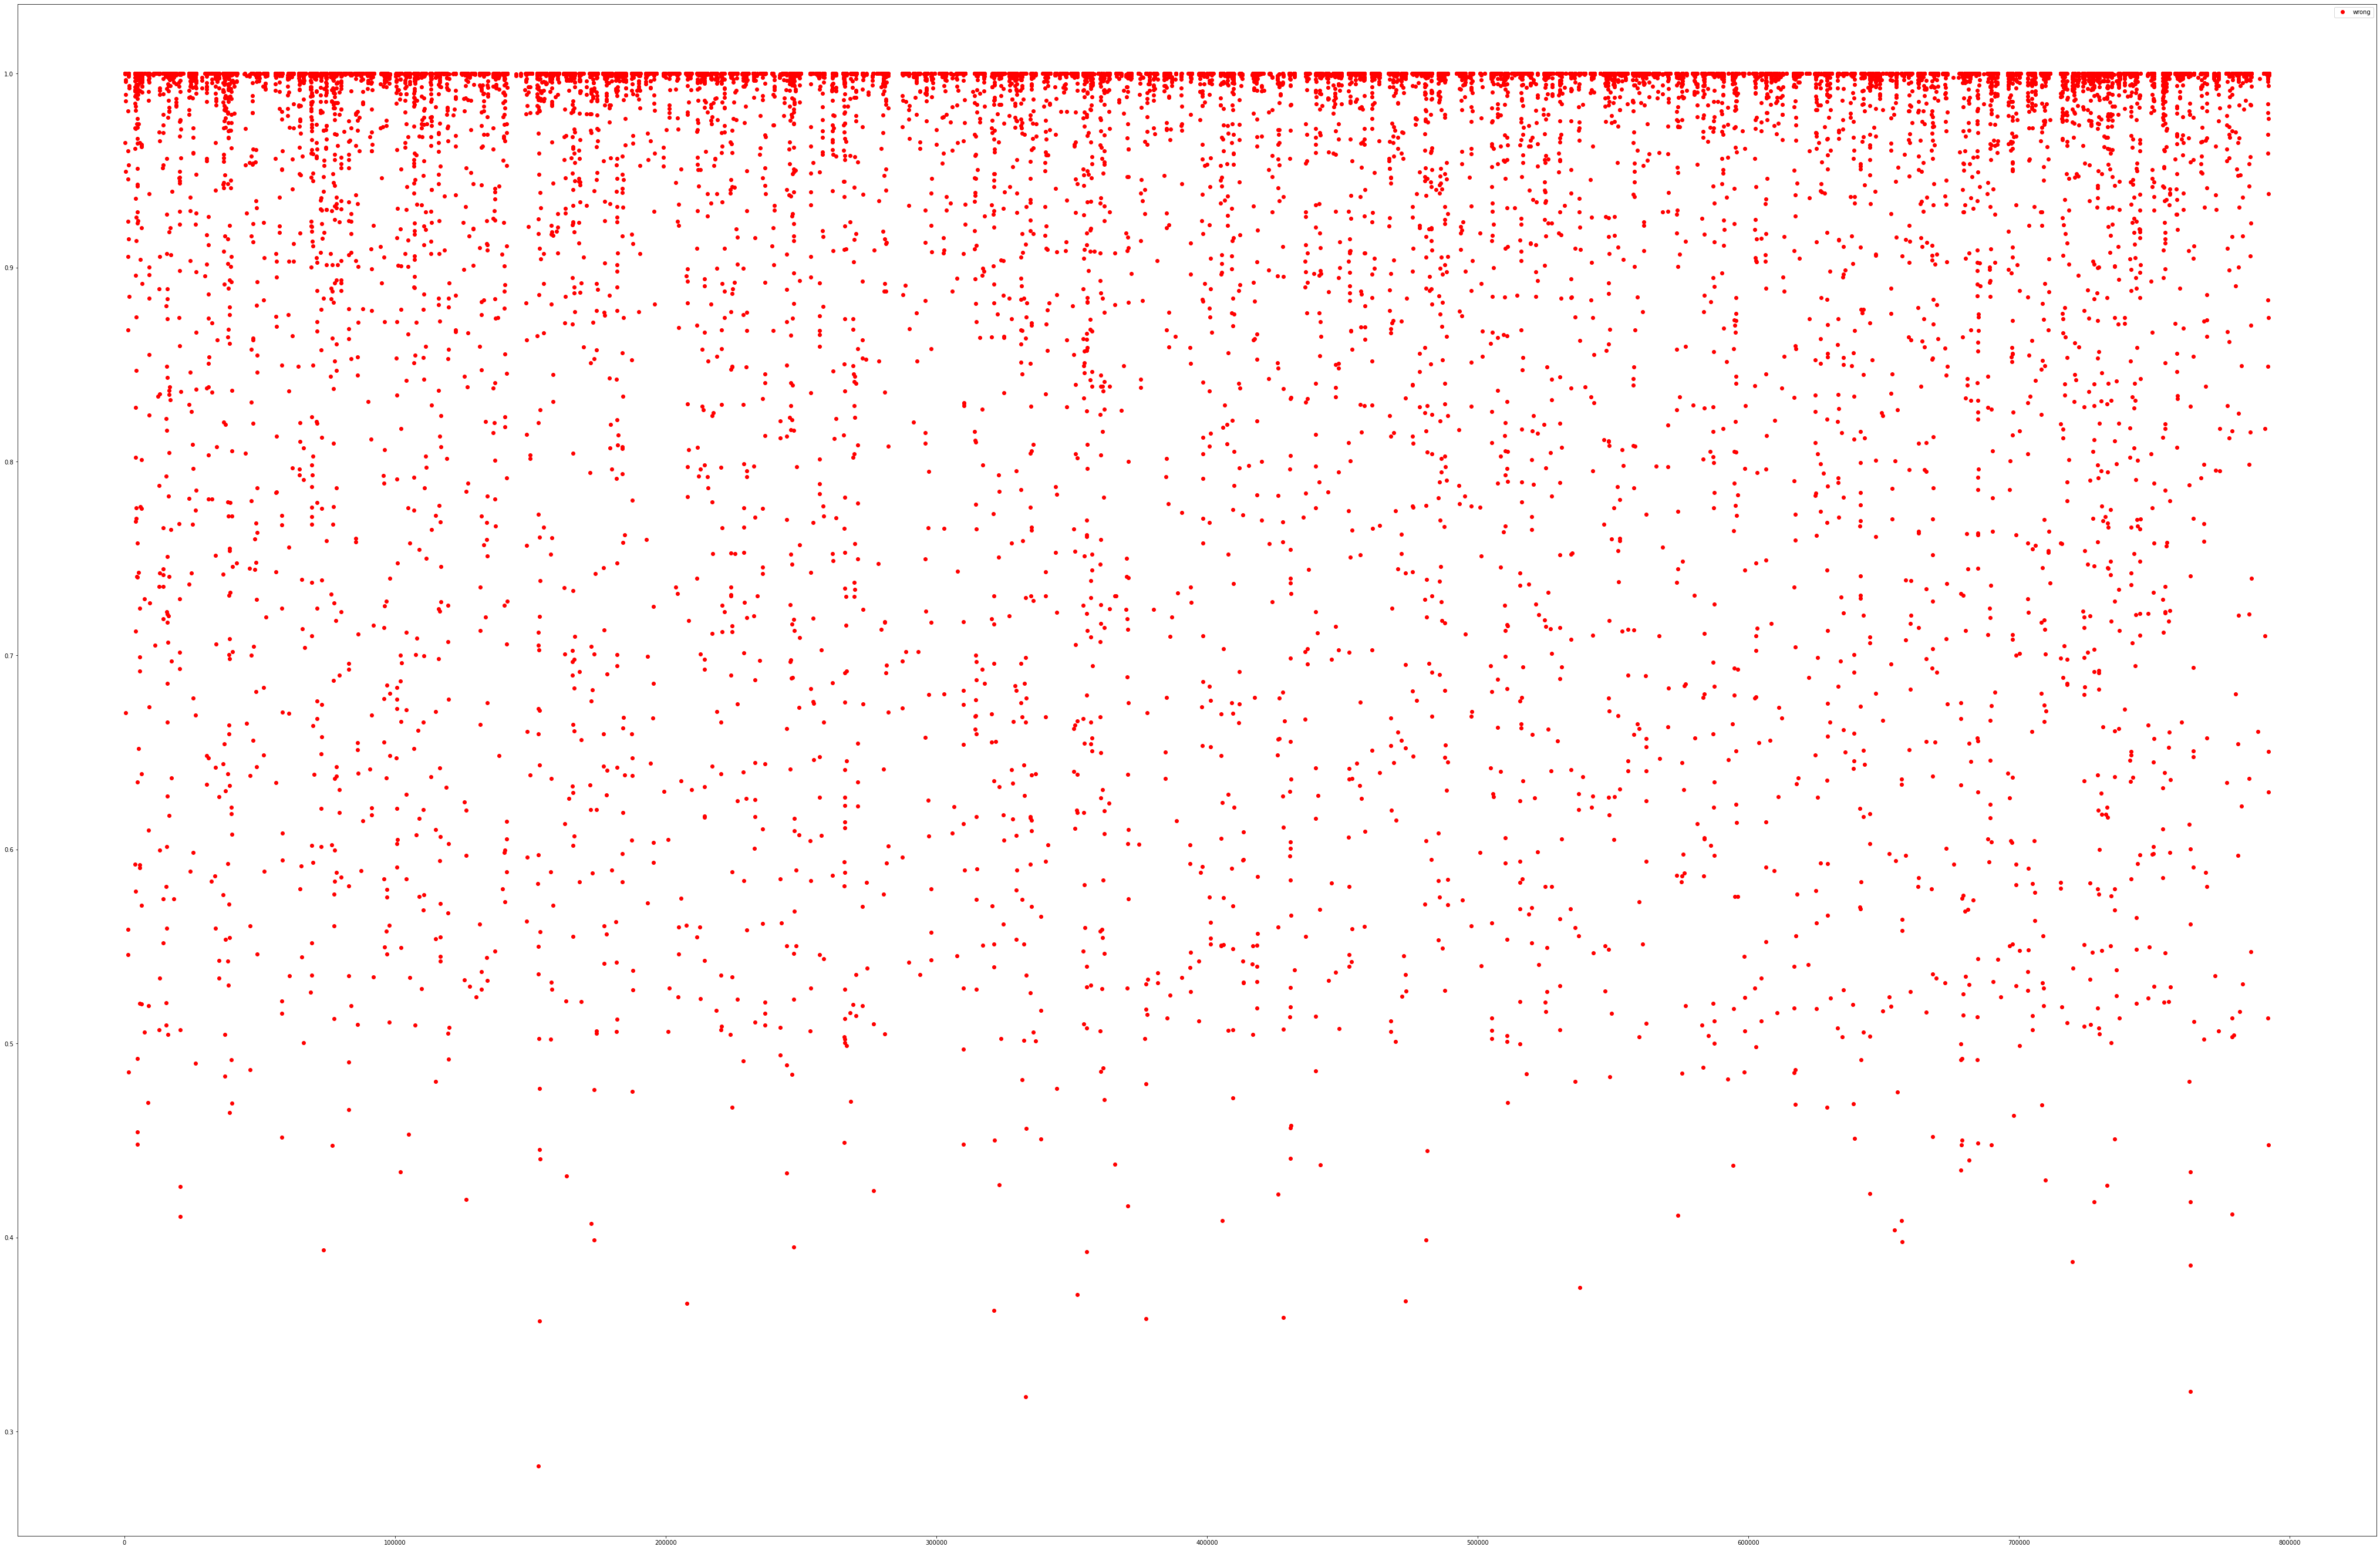

In [ ]:

confidence.plot(y=['wrong'], style=['ro'], figsize=(72,48))

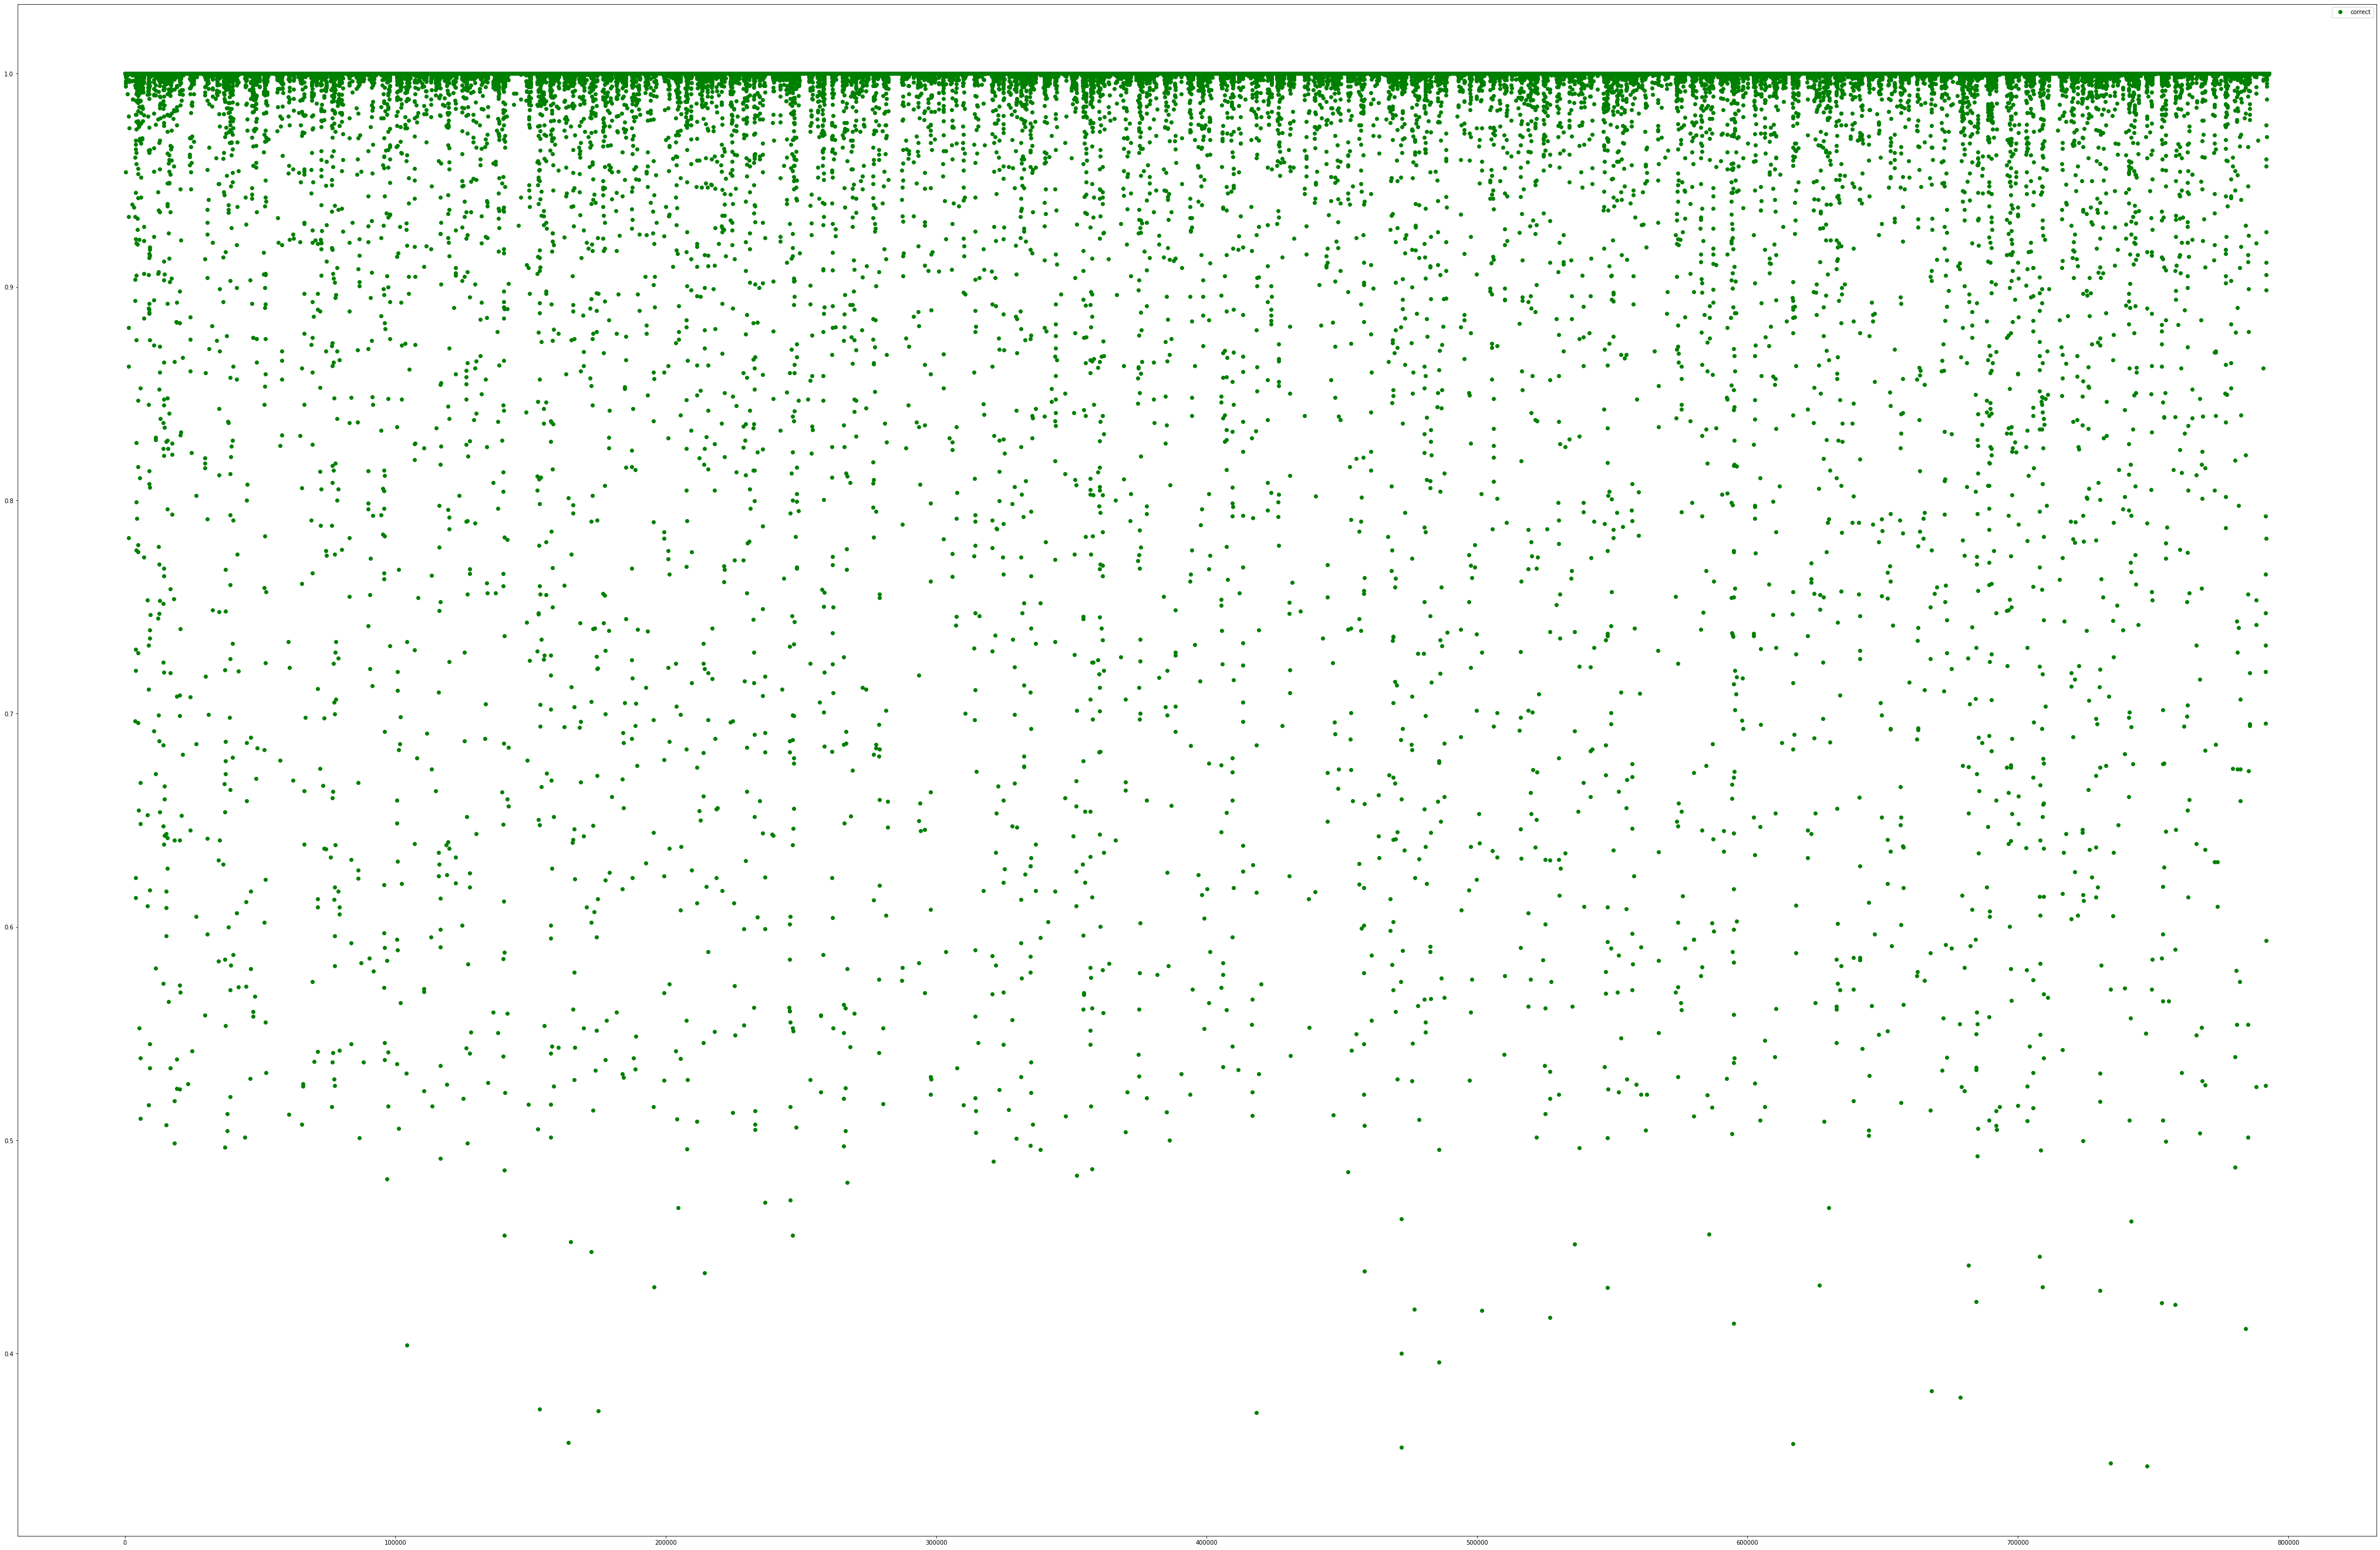

In [ ]:
confidence.plot(y=['correct'], style=['go'], figsize=(72,48))